In [1]:
import pandas as pd
import numpy as np
import os,seaborn
from pandas import Series

from os.path import join, getsize

%matplotlib inline
import matplotlib.pyplot as plt

import sys

In [116]:
from pykalman import KalmanFilter

kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
kf = kf.em(measurements, n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [117]:
smoothed_states_missing

array([[ -44.95439637,   36.26317577],
       [-104.86359192,   82.54726546],
       [-118.57121949,  107.68371762],
       [-117.31876432,  120.61972265],
       [-112.83730577,  126.96139765],
       [-108.85404218,  129.92339644],
       [-106.1207367 ,  131.23513052],
       [-104.46287034,  131.77940815],
       [-103.53351538,  131.98577125],
       [-103.04303741,  132.05355691],
       [-102.79758855,  132.0708698 ],
       [-102.68077061,  132.07505358],
       [-102.62617995,  132.08216217],
       [-102.59390721,  132.10072487],
       [-102.55117296,  132.13741694],
       [-102.45219929,  132.19712839],
       [-102.20931461,  132.27525195],
       [-101.64337295,  132.33325926],
       [-100.39610333,  132.2360337 ],
       [ -97.78174681,  131.60468708],
       [ -92.55833061,  129.49119801],
       [ -82.63274055,  123.69476439],
       [ -64.83846448,  109.3924808 ],
       [ -35.27948737,   76.53009653],
       [ -64.48215143,   88.70417068],
       [ -54.50594619,   

In [12]:
# 将四项转换为数组形式
vehicle = pd.read_csv("../data/attachment_1_100/AA00004.csv")

lng_lat_time_speed = vehicle[["lng","lat","location_time","gps_speed"]].values

In [153]:
for i in index:
    res.loc[i] = np.ma.masked

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals.py:940: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals.py:940: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals.py:940: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals.py:940: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals.py:940: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals.py:940: UserWarning: Warning: converting a masked element to nan.
  values[indexer] = value
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\int

In [105]:
vehicle = pd.read_csv("../data/attachment_1_100/AA00004.csv")
# 将其中的四项转化为 narray
# lng_lat_time_speed = vehicle[["lng","lat","location_time","gps_speed"]].values

vehicle['location_time'] = pd.to_datetime(vehicle['location_time'])

grouper = pd.Grouper(key='location_time', freq='1s')

res = vehicle.groupby(grouper).first().reset_index()
res.to_csv("test.csv")

## 将路线分段

In [142]:
# 获取附件一中的所有文件路径
filepath = np.array([])
for root, dirs, files in os.walk('../data/attachment_1_100/'):
    filepath = np.concatenate((filepath,np.array([join(root, name) for name in files])))
print("\t".join(filepath[:3]))

../data/attachment_1_100/AA00001.csv	../data/attachment_1_100/AA00004.csv	../data/attachment_1_100/AA00052.csv


In [143]:
# 加载数据

j = 1
vehicle = pd.read_csv(filepath[j])

vehicle['location_time'] = pd.to_datetime(vehicle['location_time'])

# 计算时间戳的间隔
time_diff = np.diff(vehicle["location_time"])/np.timedelta64(1, 's')
time_diff = np.append(time_diff,0)

vehicle['time_diff'] = time_diff 

# 筛选出时间戳间隔大于5min的索引项
big_diff = (vehicle[vehicle['time_diff']>300].index + 1).tolist()

print(big_diff)

[5030, 9144, 10200, 17310, 17514, 27140, 28772, 30108, 40924, 40970, 40985, 41900, 51359, 51778]


In [145]:
# 根据索引项将数据文件分段
filename = filepath[j].split("/")[-1].split(".")[0]

vehicle[:big_diff[0]].to_csv("data/process_file/" + filename + "_0.csv")

for i in range(len(big_diff)-1):
    vehicle[big_diff[i]:big_diff[i+1]].to_csv("data/process_file/"+ filename + "_" + str(i+1) +".csv")
vehicle[big_diff[-1]:].to_csv("data/process_file/" + filename + "_"+ str(len(big_diff)) +".csv")

- - - 

## 将路线分段后开始补点

In [77]:
part_vehicle = pd.read_csv("data/process_file/AA00004_0.csv")
part_vehicle['location_time'] = pd.to_datetime(part_vehicle['location_time'])

grouper = pd.Grouper(key='location_time', freq='1s')


# res为补完点后的dataframe
res = part_vehicle.groupby(grouper).first().reset_index()

 - - -

## 尝试使用均值进行填充缺失值

In [102]:
lng_lat = res[["lng","lat"]].values
isnull_state = np.isnan(lng_lat)
nan_index = np.array(sorted(list(set(np.where(isnull_state)[0]))))

for i in nan_index:
    if np.isnan(lng_lat[i+1])[0]:
        lng_lat[i] = lng_lat[i-1]
#         print("{}|isnan：{}".format(lng_lat[i],i))
    else:
        lng_lat[i] = np.mean([lng_lat[i-1],lng_lat[i+1]],axis=0)
#         print("{}|nonenan：{}".format(lng_lat[i],i))
        
isnull_state = np.isnan(lng_lat)
nan_index = np.array(list(set(np.where(isnull_state)[0])))

print(nan_index)

[]


## 尝试使用kalman算法进行补点及光滑线路

In [151]:
lng_lat = res[["lng","lat"]].values[:30]

In [152]:
isnull_state = np.isnan(lng_lat)
nan_index = np.array(list(set(np.where(isnull_state)[0])))
for i in nan_index:
    lng_lat[i] = np.ma.masked

In [153]:
from pykalman import KalmanFilter

random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [-0.1, 0.1]
observation_matrix = np.eye(2) + random_state.randn(2, 2) * 0.1
observation_offset = [1.0, -1.0]
initial_state_mean = [5, -5]
n_timesteps = 50

# sample from model
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    transition_offsets=transition_offset,
    observation_offsets=observation_offset,
    initial_state_mean=initial_state_mean,
    random_state=0
)

# smoothed_states_all = kf.smooth(observations_all)[0]

smoothed_states_missing = kf.em(lng_lat).smooth(lng_lat)[0]

In [154]:
smoothed_states_missing

array([[67.49848539, 11.8022052 ],
       [74.71734564, 12.91606048],
       [79.23828917, 13.62617938],
       [82.15722964, 14.0868974 ],
       [84.0566327 , 14.38708203],
       [85.29399245, 14.58270254],
       [86.09849957, 14.70992196],
       [86.61877042, 14.79221458],
       [86.95078641, 14.84470966],
       [87.1553521 , 14.87704412],
       [87.27008497, 14.89517129],
       [87.31614546, 14.90242649],
       [87.3019688 , 14.90014157],
       [87.22493648, 14.88789506],
       [87.07086206, 14.86343171],
       [86.81137338, 14.82224673],
       [86.39868731, 14.7567563 ],
       [85.75681197, 14.65490166],
       [84.76756168, 14.4979325 ],
       [83.24881341, 14.25692067],
       [80.92056125, 13.88736137],
       [77.35259217, 13.32052156],
       [71.87931373, 12.44804232],
       [63.44267937, 11.08596488],
       [65.24309814, 11.39524875],
       [63.2133182 , 11.05348188],
       [71.4485275 , 12.3870502 ],
       [77.06396544, 13.27978857],
       [80.78516853,

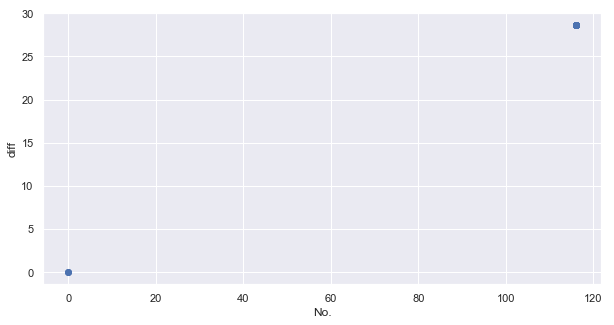

In [62]:
lng = [i[0] for i in lng_lat]
lat = [i[1] for i in lng_lat]

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Set seaborn aesthetic parameters to defaults
seaborn.set()
# plt.scatter(range(len(direction_angle_diff)),[item[0] for item in direction_angle_diff])
plt.scatter(lng,lat)
plt.ylabel("diff")
plt.xlabel("No.")
# plt.savefig("../image/direction_speed_diff/2" + filepath[j].split("/")[-1].split(".")[0] + ".jpg")
plt.show()